In [ ]:
from google.colab import drive
drive.mount('/gdrive')
root = '/gdrive/My Drive/'

Mounted at /gdrive


In [ ]:
#torch vision 설치
!pip install torchvision

#Homebrew로 libomp 설치
!brew install libomp (for OSX)
#AttributeError: module 'torch' has no attribute '_six'
!pip install torchtext -U

/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `brew install libomp (for OSX)'
     |████████████████████████████████| 6.9MB 4.8MB/s 
  Found existing installation: torchtext 0.3.1
    Uninstalling torchtext-0.3.1:
      Successfully uninstalled torchtext-0.3.1


# **Load keypoint rcnn model and load image**

In [ ]:
'''
brew install libomp (for OSX)
pip install torchtext -U
'''
import torch
import torchvision
from torchvision import models
import torchvision.transforms as T

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches

print('pytorch', torch.__version__)
print('torchvision', torchvision.__version__)

IMG_SIZE = 480
THRESHOLD = 0.95

#Download Model : torchvision.keypoint rcnn model 사용

model = models.detection.keypointrcnn_resnet50_fpn(pretrained=True).eval()

pytorch 1.7.0+cu101
torchvision 0.8.1+cu101


Downloading: "https://download.pytorch.org/models/keypointrcnn_resnet50_fpn_coco-fc266e95.pth" to /root/.cache/torch/hub/checkpoints/keypointrcnn_resnet50_fpn_coco-fc266e95.pth


torch.Size([3, 320, 480])


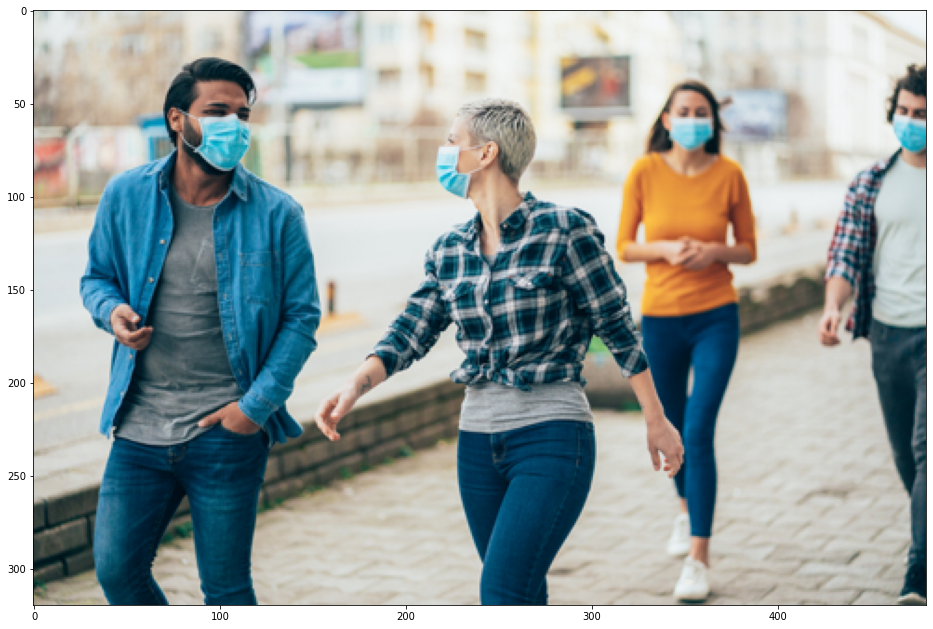

In [ ]:
#Load Image
file_path = root + 'masked_people.jpg'
img = Image.open(file_path)

#image를 가로 길이 480으로 비율 맞춤
img = img.resize((IMG_SIZE, int(img.height * IMG_SIZE / img.width)))

plt.figure(figsize=(16, 16))
plt.imshow(img)

#Image to Tensor

trf = T.Compose([
    T.ToTensor()
])

input_img = trf(img)

print(input_img.shape)

# **Find Keypoints**

dict_keys(['boxes', 'labels', 'scores', 'keypoints', 'keypoints_scores'])
[(23, 317, 19, 154), (45, 313, 154, 346), (37, 314, 313, 389), (29, 308, 421, 478)]


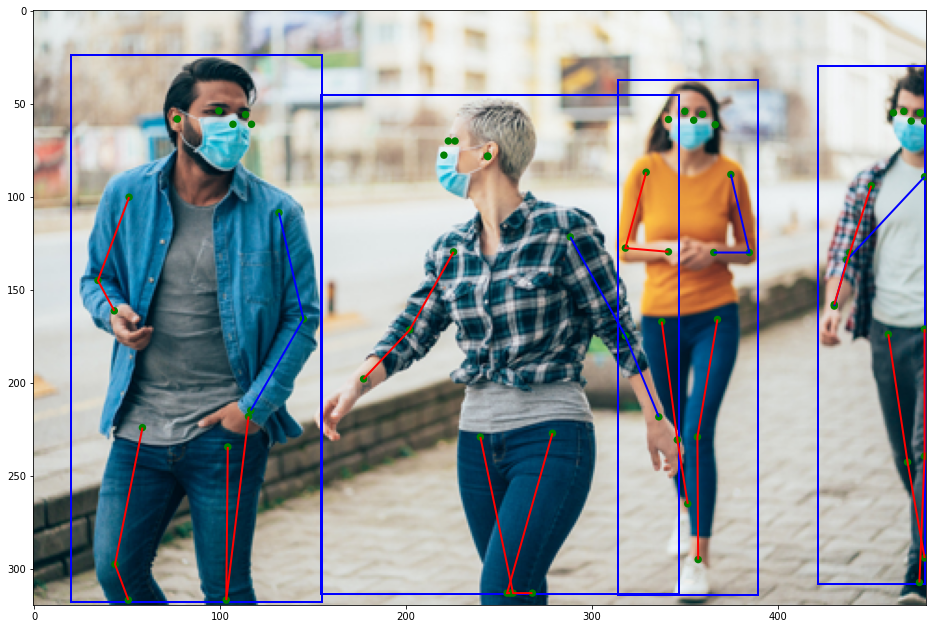

In [ ]:
#Inference

out = model([input_img])[0]

print(out.keys())

codes = [
    Path.MOVETO,
    Path.LINETO,
    Path.LINETO
]
colors = []
boxes = []
fig, ax = plt.subplots(1, figsize=(16, 16))
ax.imshow(img)

# out에 human detect한 score, keypoints값이 들어있다. 
# 그래서 keypoints는 한 사람의 17 points를 나타냄 / box는 한 사람의 human detect box를 나타냄

for box, score, keypoints in zip(out['boxes'], out['scores'], out['keypoints']):
    score = score.detach().numpy()
    if score < THRESHOLD:
        continue
    box = box.detach().numpy()
    keypoints = keypoints.detach().numpy()[:, :2]
    rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor='b', facecolor='none')
    ax.add_patch(rect)

    # 17 keypoints 을 green circle로 표시
    for k in keypoints:
        circle = patches.Circle((k[0], k[1]), radius=2, facecolor='g')
        ax.add_patch(circle)

    # draw path
    # left arm
    path = Path(keypoints[5:10:2], codes)
    line = patches.PathPatch(path, linewidth=2, facecolor='none', edgecolor='b')
    ax.add_patch(line)
    # left arm 어깨의 color
    left_r,left_g,left_b = img.getpixel((keypoints[5:10:2][0][0].astype(np.int64).item(),keypoints[5:10:2][0][1].astype(np.int64).item()))

    # right arm
    path = Path(keypoints[6:11:2], codes)
    line = patches.PathPatch(path, linewidth=2, facecolor='none', edgecolor='r')
    ax.add_patch(line)
    # right arm 어깨의 color
    right_r, right_g, right_b = img.getpixel((keypoints[6:11:2][0][0].astype(np.int64).item(),keypoints[6:11:2][0][1].astype(np.int64).item()))
    
    ### append left arm color and right arm color to colors list
    colors.append(((left_r,left_g,left_b),(right_r, right_g, right_b)))
    
    # left leg
    path = Path(keypoints[11:16:2], codes)
    line = patches.PathPatch(path, linewidth=2, facecolor='none', edgecolor='r')
    ax.add_patch(line)

    # right leg
    path = Path(keypoints[12:17:2], codes)
    line = patches.PathPatch(path, linewidth=2, facecolor='none', edgecolor='r')
    ax.add_patch(line)

    # #crop human detected box and show
    boxes.append((int(box[1]),int(box[3]),int(box[0]),int(box[2])))
    # cropped_img = np.array(img)
    # cropped_img = cropped_img[int(box[1]):int(box[3]),int(box[0]):int(box[2]),:]
    # plt.imshow(cropped_img)
    # plt.axis('off')
    # plt.show()

print(boxes)

In [ ]:
average_colors = []
for i in range(len(colors)):
    average_colors.append(((colors[i][0][0]+colors[i][1][0])/2,(colors[i][0][1]+colors[i][1][1])/2,(colors[i][0][2]+colors[i][1][2])/2))

print(average_colors)

[(7.5, 109.0, 148.0), (117.5, 135.0, 142.5), (211.5, 125.0, 56.5), (128.0, 136.0, 142.5)]


In [ ]:
##### just for check extracted colors #####

def rgb_to_hex(tuple):
    r, g, b = int(tuple[0]), int(tuple[1]), int(tuple[2])
    return '#' + hex(r)[2:].zfill(2) + hex(g)[2:].zfill(2) + hex(b)[2:].zfill(2)




# figure, axes = plt.subplots()
# axes.set_aspect(1)

# for i in range(len(colors)):
#     draw_circle = plt.Circle((0.2+(i+0.5)/6,0.2+i/6),0.1, color = rgb_to_hex(colors[i][0]))
#     draw_circle2 = plt.Circle((0.2+i/6,0.2+i/6),0.1, color = rgb_to_hex(colors[i][1]))
#     axes.add_artist(draw_circle)
#     axes.add_artist(draw_circle2)
    
# plt.show()

(7.5, 109.0, 148.0)
(117.5, 135.0, 142.5)
(211.5, 125.0, 56.5)
(128.0, 136.0, 142.5)


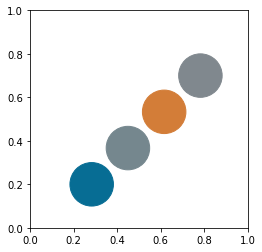

In [ ]:
### just for check extracted average colors ####

figu, ax = plt.subplots()
ax.set_aspect(1)

for i in range(len(average_colors)):
    print(average_colors[i])
    draw_circle = plt.Circle((0.2+(i+0.5)/6,0.2+i/6),0.1, color = rgb_to_hex(average_colors[i]))
    ax.add_artist(draw_circle)
    
plt.show()

In [ ]:
def get_average_color(x, y, n, image):
    """ Returns a 3-tuple containing the RGB value of the average color of the
    given square bounded area of length = n whose origin (top left corner) 
    is (x, y) in the given image"""

    r, g, b = 0, 0, 0
    count = 0
    for s in range(x, x+n+1):
        for t in range(y, y+n+1):
            pixlr, pixlg, pixlb = image.getpixel((x, y))
            r += pixlr
            g += pixlg
            b += pixlb
            count += 1
    return ((r/count), (g/count), (b/count))


In [ ]:
#Download Model : torchvision.keypoint rcnn model 사용
model = models.detection.keypointrcnn_resnet50_fpn(pretrained=True).eval()

In [ ]:

def extract_clothes_color(model, img):
    #Image to Tensor
    # print(type(img))
    trf = T.Compose([
        T.ToTensor()
    ])
    input_img = trf(img)
    out = model([input_img])[0]

    codes = [
        Path.MOVETO,
        Path.LINETO,
        Path.LINETO
    ]

    fig, ax = plt.subplots(1, figsize=(16, 16))
    ax.imshow(img)

    # out에 human detect한 score, keypoints값이 들어있다. 
    # 그래서 keypoints는 한 사람의 17 points를 나타냄 / box는 한 사람의 human detect box를 나타냄

    for box, score, keypoints in zip(out['boxes'], out['scores'], out['keypoints']):
        score = score.detach().numpy()
        if score < THRESHOLD:
            continue
        box = box.detach().numpy()
        keypoints = keypoints.detach().numpy()[:, :2]
        rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor='b', facecolor='none')
        print('box: ',box)
        ax.add_patch(rect)

        # 17 keypoints 을 green circle로 표시
        # for k in keypoints:
            # circle = patches.Circle((k[0], k[1]), radius=5, facecolor='g')
            # ax.add_patch(circle)
        # left arm 어깨의 color
        left_x = keypoints[5:10:2][0][0].astype(np.int64).item()
        left_y = keypoints[5:10:2][0][1].astype(np.int64).item()
        left_r,left_g,left_b = img.getpixel((left_x, left_y))
        # right arm 어깨의 color
        right_x = keypoints[6:11:2][0][0].astype(np.int64).item()
        right_y = keypoints[6:11:2][0][1].astype(np.int64).item()
        right_r, right_g, right_b = img.getpixel((right_x, right_y))

        # draw clothes color to image
        # shoulder_circle1 = patches.Circle((left_x,left_y),radius = 30, facecolor = rgb_to_hex((left_r,left_g,left_b)), edgecolor = 'white')
        # shoulder_circle2 = patches.Circle((right_x,right_y),radius = 30, facecolor = rgb_to_hex((right_r,right_g,right_b)), edgecolor='white')
        # ax.add_patch(shoulder_circle1)
        # ax.add_patch(shoulder_circle2)
        
    return (left_r,left_g,left_b),(right_r, right_g, right_b)

box:  [  94.84368  294.90286  940.73816 1068.889  ]


((64, 34, 26), (93, 92, 134))

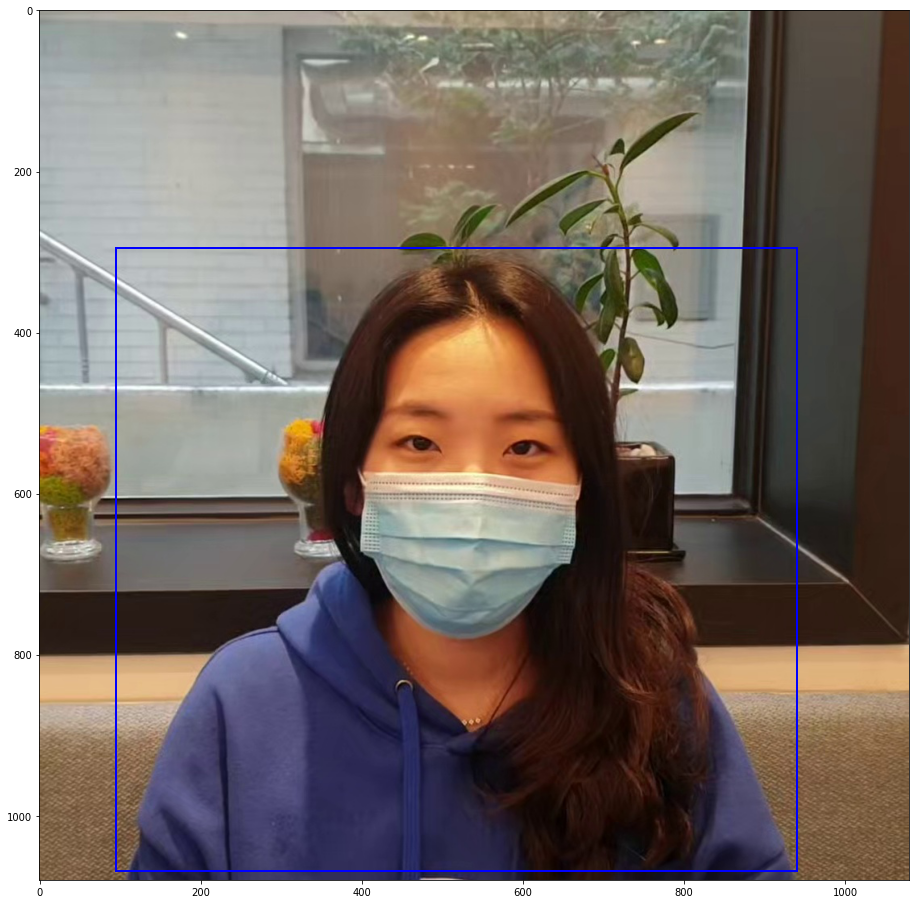

In [ ]:
i = 10
img = Image.open('/gdrive/My Drive/mp4_capture/{0:05d}.jpg'.format(i))
# print(type(img))
extract_clothes_color(model,img)

In [ ]:
def extract_clothes_color(model, img):
    #Image to Tensor
    trf = T.Compose([
        T.ToTensor()
    ])
    input_img = trf(img)
    out = model([input_img])[0]

    codes = [
        Path.MOVETO,
        Path.LINETO,
        Path.LINETO
    ]

    for box, score, keypoints in zip(out['boxes'], out['scores'], out['keypoints']):
        score = score.detach().numpy()
        if score < THRESHOLD:
            continue
        box = box.detach().numpy()
        keypoints = keypoints.detach().numpy()[:, :2]

        # left arm 어깨의 color
        left_x = keypoints[5:10:2][0][0].astype(np.int64).item()
        left_y = keypoints[5:10:2][0][1].astype(np.int64).item()
        left_r,left_g,left_b = img.getpixel((left_x, left_y))
        # right arm 어깨의 color
        right_x = keypoints[6:11:2][0][0].astype(np.int64).item()
        right_y = keypoints[6:11:2][0][1].astype(np.int64).item()
        right_r, right_g, right_b = img.getpixel((right_x, right_y))
        
    return (left_r,left_g,left_b),(right_r, right_g, right_b)